In [17]:
import lenstronomy
print(lenstronomy.__version__)

1.12.5


In [45]:
import numpy as np
import os
import time
import corner
from astropy.io import fits
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot


/var/folders/sl/ck56tyxs0fxf0m9pr2t9jjbc0000gn/T/ipykernel_1421/1964531102.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(kernel))


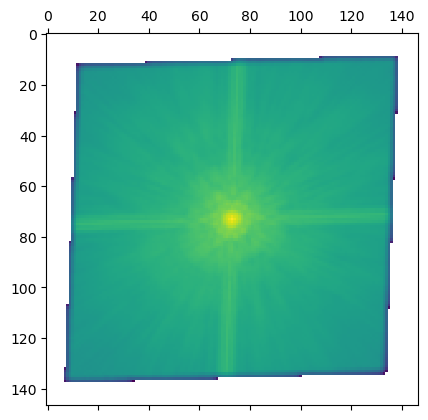

In [47]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, '212/psf_example (1).fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

    
# data specifics
background_rms = .2  #  background noise per pixel (Gaussian rms value)
exp_time = 80.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 80  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91  # PSF kernel size (odd number required).


# initial input simulation
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)

/var/folders/sl/ck56tyxs0fxf0m9pr2t9jjbc0000gn/T/ipykernel_1421/2767858739.py:60: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


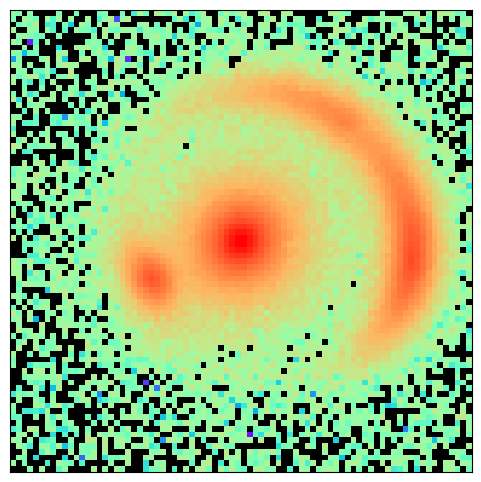

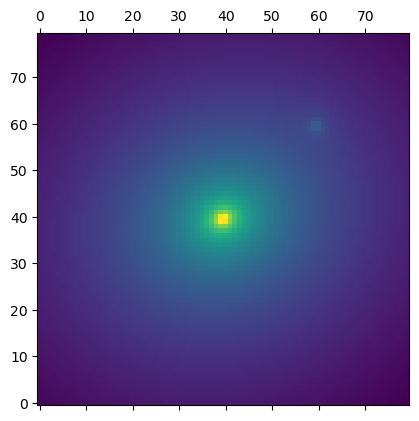

In [29]:
# lensing quantities
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_sie = {'theta_E': 1.2, 'e1': 0.05, 'e2': 0.05, 'center_x': 0, 'center_y': 0}
kwargs_nfw = {'alpha_Rs': 0.02, 'Rs': 0.1, 'center_x': 1., 'center_y': 1}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SIE', 'SHEAR', 'NFW']
kwargs_lens = [kwargs_sie, kwargs_shear, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_x = 0.3
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8  # Position angle (radians) and axis ratio (q = b/a)
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#n=1, exponential profile, for spiral galaxy
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)

# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False} 

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)


# display the initial simulated image
cmap_string = 'rainbow'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4 #max and min of color scales: pixels at log_10 (v), where -4 is 10^-4
v_max = 2 #2 is 100

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

# and here we compute the convergence at each pixel position
x_coords, y_coords = data_class.pixel_coordinates
kappa = lens_model_class.kappa(util.image2array(x_coords), util.image2array(y_coords), kwargs_lens)
plt.matshow(util.array2image(np.log10(kappa)), origin='lower')
plt.show()

In [31]:
#######################################
### Recovering the input parameters WITHOUT the clump
#######################################


# First we only model the macro-model
lens_model_simple_list = ['SIE', 'SHEAR']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_simple_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}



# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {}

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,}

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, []]


mpi = False  # MPI possible, but not supported through that notebook.

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=mpi)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]

Max iteration reached! Stopping.
-1.2274690477930585 reduced X^2 of best position
-3915.01252793596 log likelihood
6379 effective number of data points
[{'theta_E': 1.205844000071697, 'e1': 0.06240372053168576, 'e2': 0.054971950715968304, 'center_x': 0.004204142595046491, 'center_y': 0.018849118093697215}, {'gamma1': 0.010600609201268357, 'gamma2': -0.054440723072404704, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.09949554970435136, 'n_sersic': 1.0121187563488703, 'e1': 0.06488181278663861, 'e2': 0.09918626786731487, 'center_x': 0.28967322167867293, 'center_y': 0.11563613475156899}] source result
[{'amp': 1, 'R_sersic': 0.20008008667600657, 'n_sersic': 1.9334114347339373, 'e1': -0.009972941919756631, 'e2': 0.053618843004189926, 'center_x': -1.4823348581255566e-05, 'center_y': -0.0007966434552826424}] lens light result
[] point source result
[] tracer source result
{} special param result
19.412380933761597 time used for  PSO
19.43214988708496 total time needed for com

-1.2234414149799875 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.2234414149799875


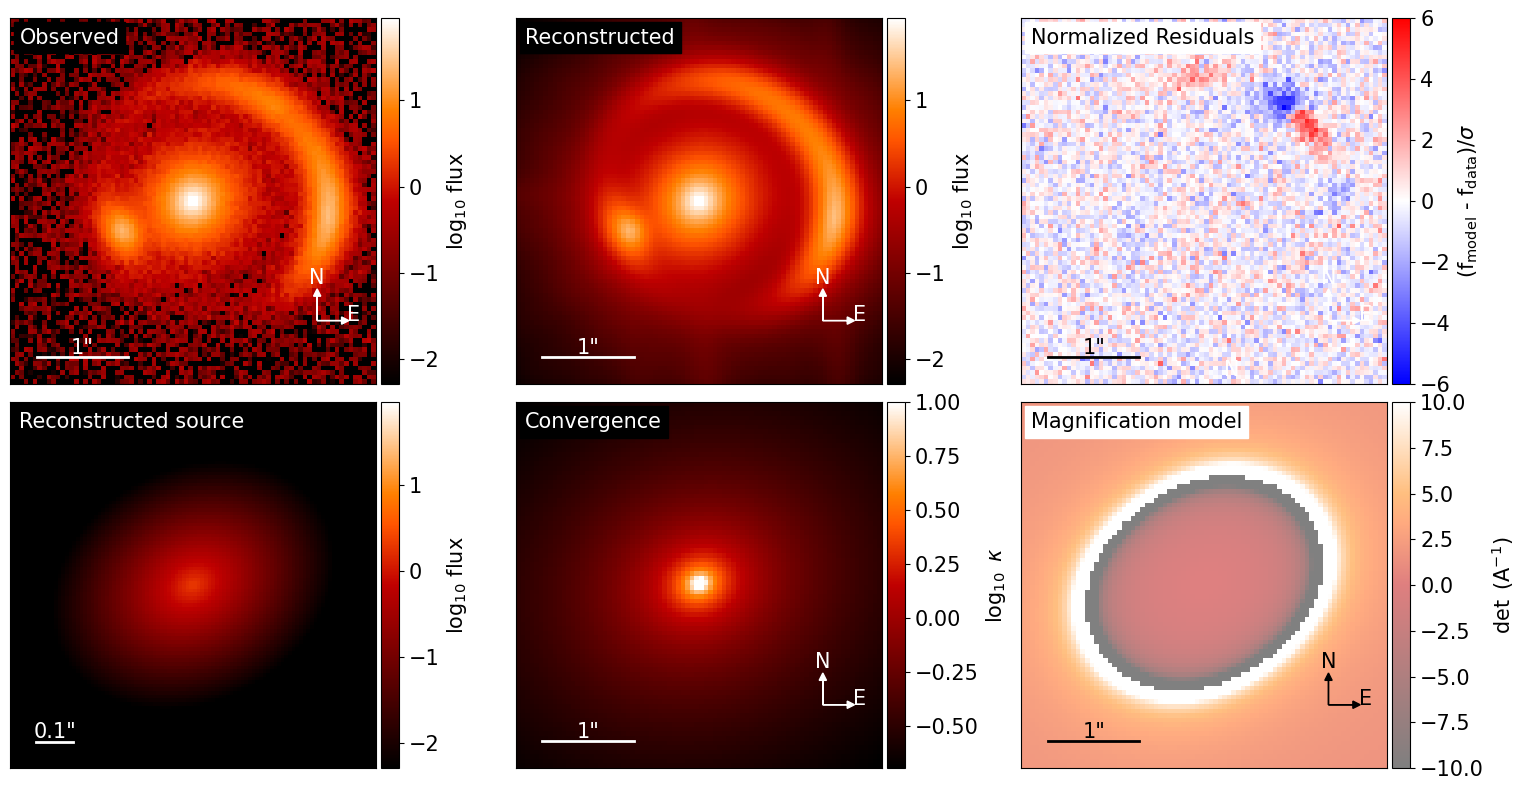

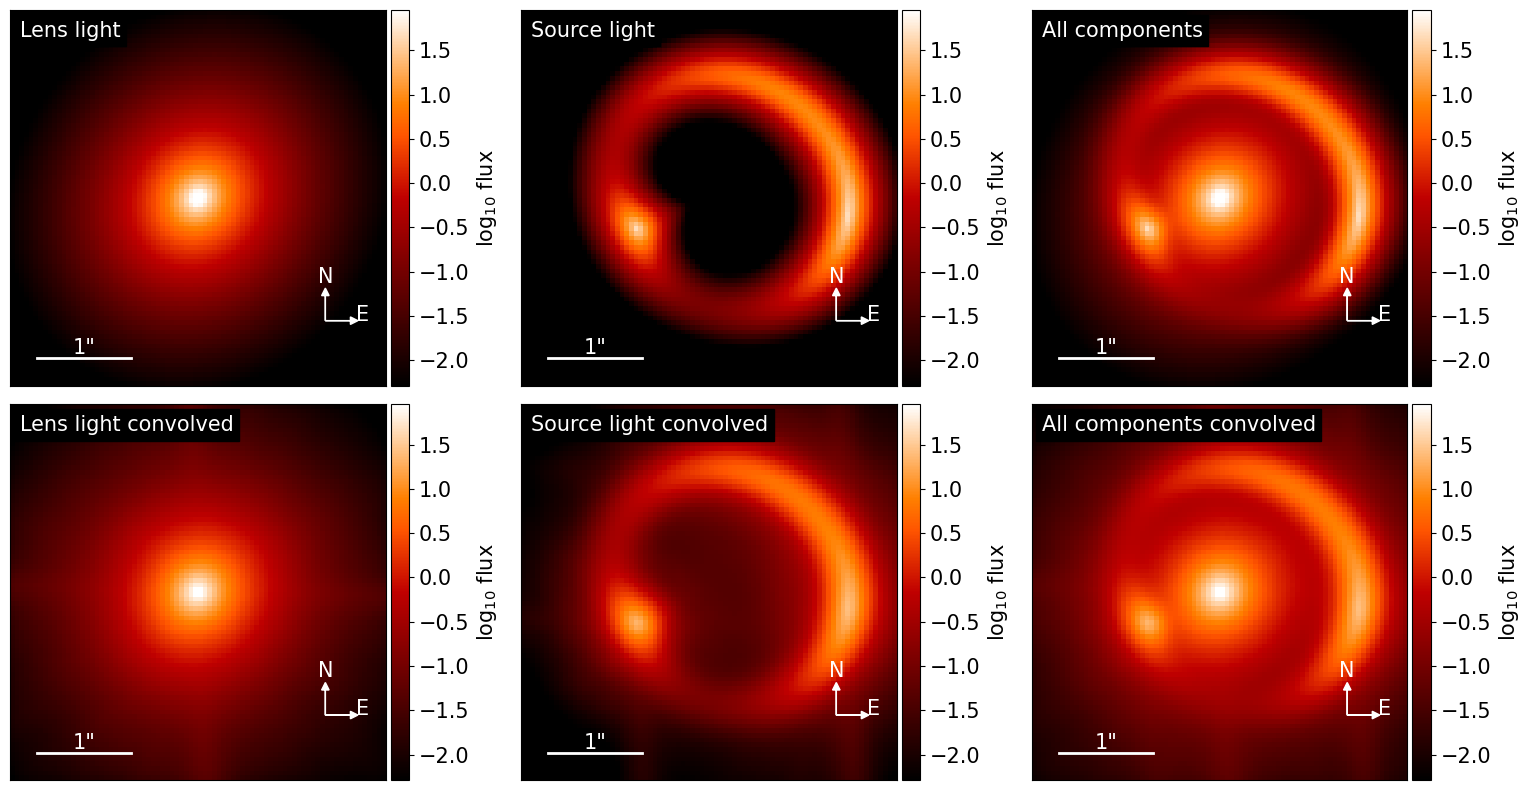

{'kwargs_lens': [{'theta_E': 1.205844000071697, 'e1': 0.06240372053168576, 'e2': 0.054971950715968304, 'center_x': 0.004204142595046491, 'center_y': 0.018849118093697215}, {'gamma1': 0.010600609201268357, 'gamma2': -0.054440723072404704, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 3901.044269558733, 'R_sersic': 0.09949554970435136, 'n_sersic': 1.0121187563488703, 'e1': 0.06488181278663861, 'e2': 0.09918626786731487, 'center_x': 0.28967322167867293, 'center_y': 0.11563613475156899}], 'kwargs_lens_light': [{'amp': 8054.101451589634, 'R_sersic': 0.20008008667600657, 'n_sersic': 1.9334114347339373, 'e1': -0.009972941919756631, 'e2': 0.053618843004189926, 'center_x': -1.4823348581255566e-05, 'center_y': -0.0007966434552826424}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


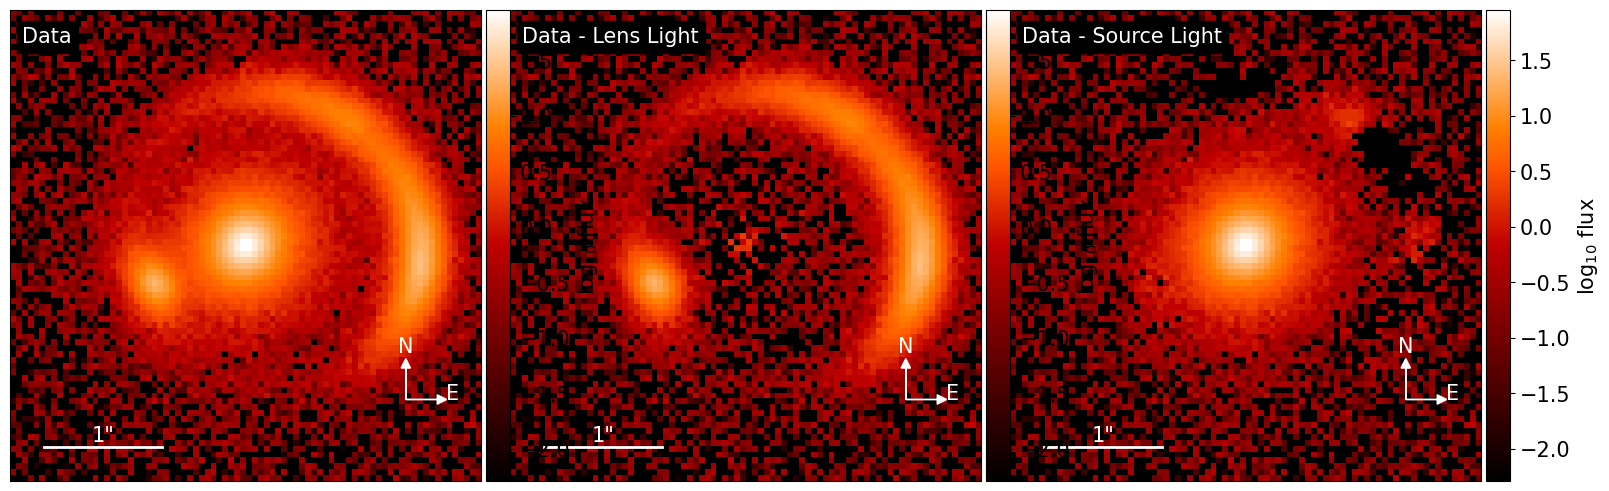

In [32]:
###########################
### analyse model output
###########################

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [33]:
#######################################
### Recovering the input parameters WITH the clump
#######################################


lens_model_substructure_list = ['SIE', 'SHEAR', 'NFW']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


fixed_lens.append({})
kwargs_lens_init.append({'alpha_Rs': 0.01, 'Rs': 0.05, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.01, 'Rs': 0.05, 'center_x': 3, 'center_y': 3})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 0.0001, 'center_x': -3, 'center_y': -3})
kwargs_upper_lens.append({'alpha_Rs': 1., 'Rs': 2, 'center_x': 3, 'center_y': 3})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.01, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 800, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


100%|█████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]

Max iteration reached! Stopping.
-1.012194622658294 reduced X^2 of best position
-3226.3703597233125 log likelihood
6375 effective number of data points
[{'theta_E': 1.1988826813477378, 'e1': 0.05029861197614457, 'e2': 0.051042473896413296, 'center_x': 0.0005216847602204968, 'center_y': -0.003064542570391051}, {'gamma1': -0.0003892901922142607, 'gamma2': -0.04797587165371777, 'ra_0': 0, 'dec_0': 0}, {'Rs': 0.14403712737307514, 'alpha_Rs': 0.02061525661624885, 'center_x': 0.9950612600985527, 'center_y': 1.001773847157215}] lens result
[{'amp': 1, 'R_sersic': 0.10031151209921493, 'n_sersic': 1.0243800381068702, 'e1': 0.06064746112952033, 'e2': 0.09169346835685399, 'center_x': 0.30113892843649204, 'center_y': 0.09771796758830413}] source result
[{'amp': 1, 'R_sersic': 0.2015602407545639, 'n_sersic': 2.03556761387795, 'e1': -0.009019374577018725, 'e2': 0.054566623612924955, 'center_x': -0.00013524980237472866, 'center_y': -0.00039540234486454615}] lens light result
[] point source result
[

-1.0082407374135351 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.008240737413535


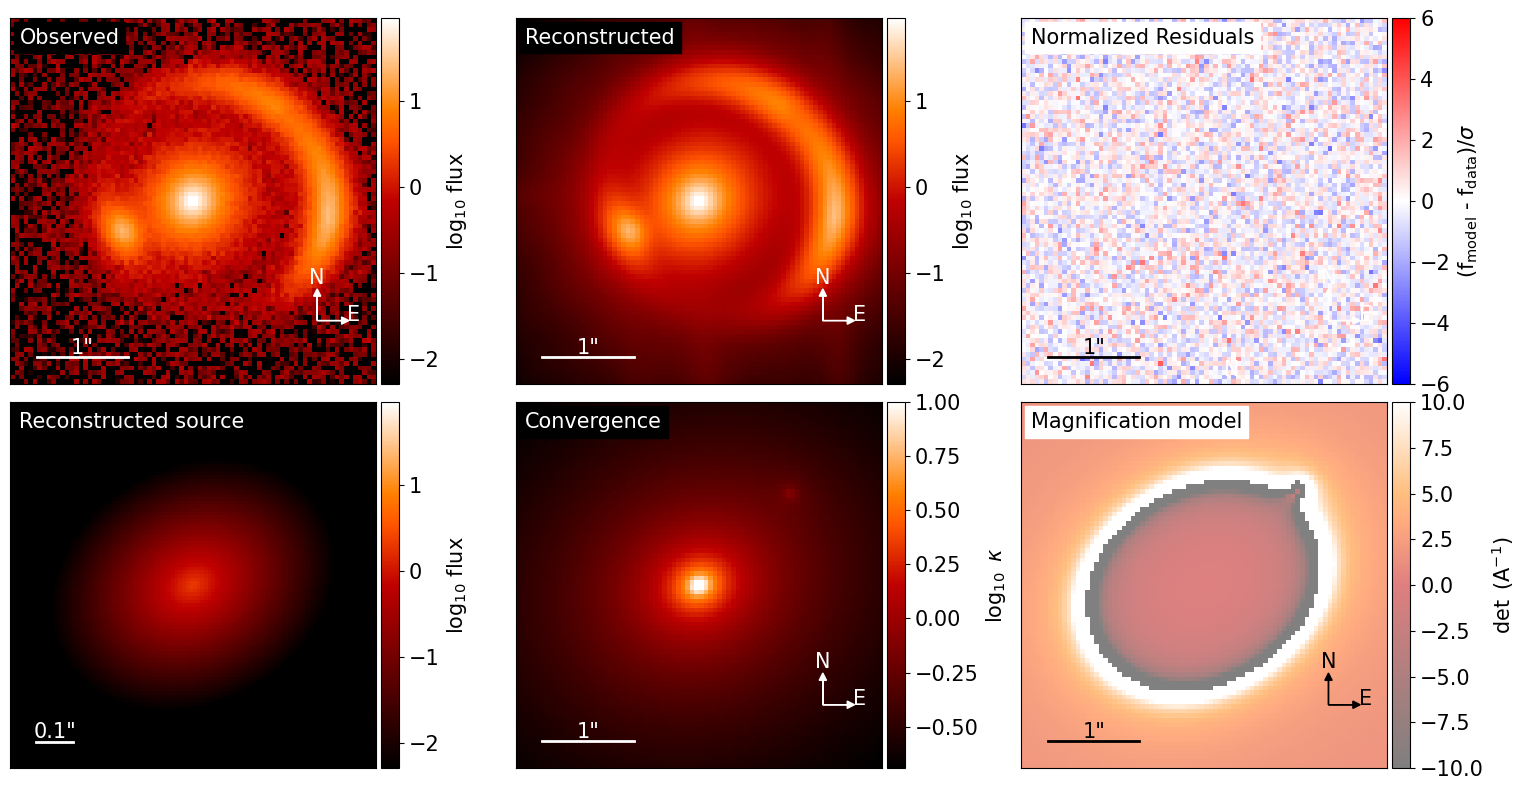

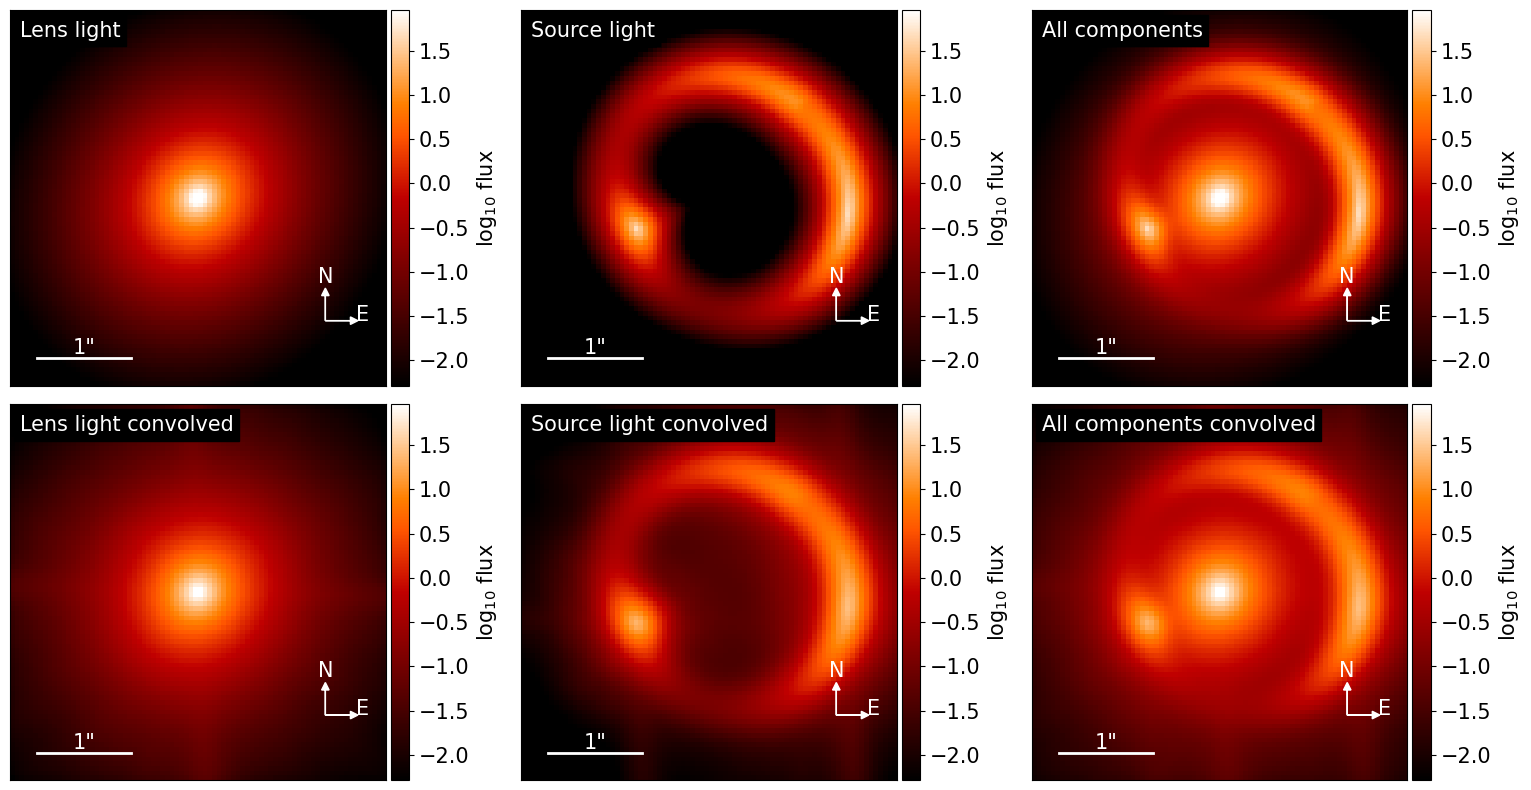

{'kwargs_lens': [{'theta_E': 1.1988826813477378, 'e1': 0.05029861197614457, 'e2': 0.051042473896413296, 'center_x': 0.0005216847602204968, 'center_y': -0.003064542570391051}, {'gamma1': -0.0003892901922142607, 'gamma2': -0.04797587165371777, 'ra_0': 0, 'dec_0': 0}, {'Rs': 0.14403712737307514, 'alpha_Rs': 0.02061525661624885, 'center_x': 0.9950612600985527, 'center_y': 1.001773847157215}], 'kwargs_source': [{'amp': 3897.262757083272, 'R_sersic': 0.10031151209921493, 'n_sersic': 1.0243800381068702, 'e1': 0.06064746112952033, 'e2': 0.09169346835685399, 'center_x': 0.30113892843649204, 'center_y': 0.09771796758830413}], 'kwargs_lens_light': [{'amp': 7823.123122770758, 'R_sersic': 0.2015602407545639, 'n_sersic': 2.03556761387795, 'e1': -0.009019374577018725, 'e2': 0.054566623612924955, 'center_x': -0.00013524980237472866, 'center_y': -0.00039540234486454615}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


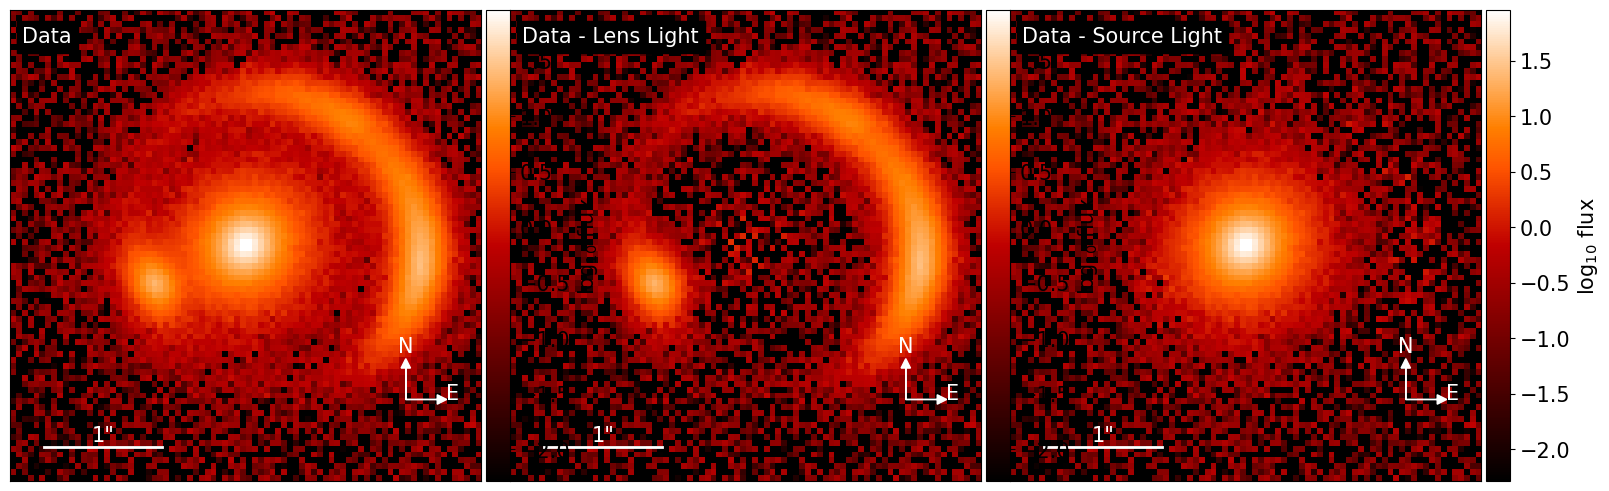

In [37]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [39]:
#######################################
### MCMC
#######################################

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_sie)
#kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


fixed_lens.append({})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][2])
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.05, 'Rs': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 0.0001, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens.append({'alpha_Rs': 1., 'Rs': 2, 'center_x': 2, 'center_y': 2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 900, 'n_run': 900, 'walkerRatio': 8, 'sigma_scale': 0.2}]]
start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')


MCMC selected. Sampling with default option emcee.


100%|███████████████████████████████████████| 1800/1800 [10:45<00:00,  2.79it/s]

Computing the MCMC...
Number of walkers =  184
Burn-in iterations:  900
Sampling iterations (in current run): 1800
645.6274979114532 time taken for MCMC sampling
646.0513157844543 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


number of non-linear parameters in the MCMC process:  23
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'Rs_lens2', 'alpha_Rs_lens2', 'center_x_lens2', 'center_y_lens2', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  165600


/var/folders/sl/ck56tyxs0fxf0m9pr2t9jjbc0000gn/T/ipykernel_1421/1013356420.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


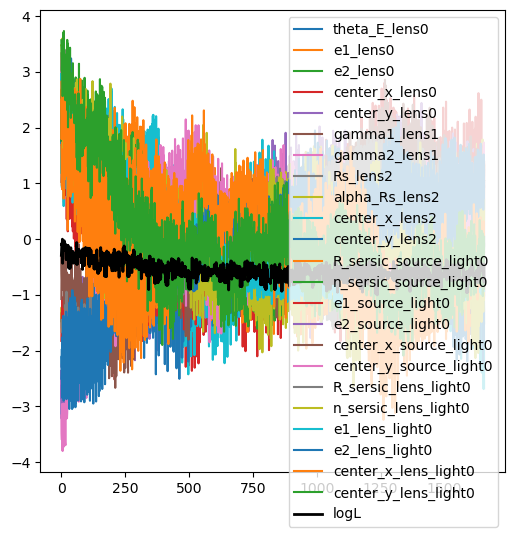

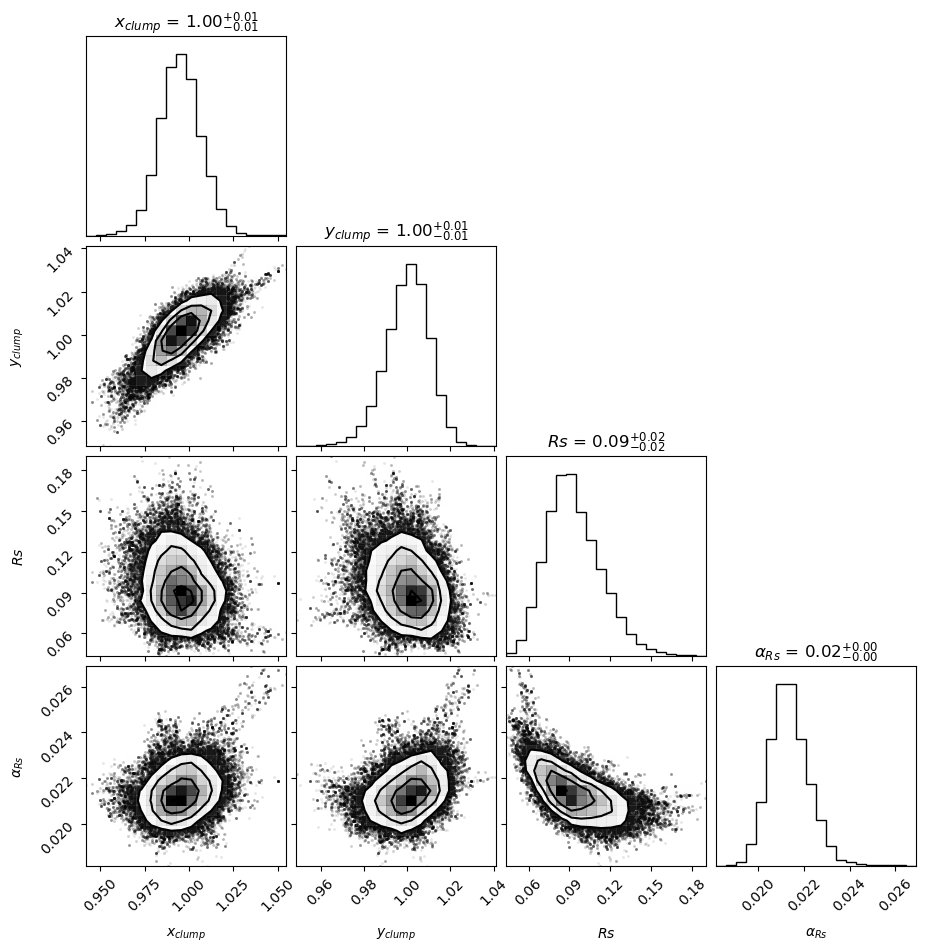

In [41]:
######
## PLOTING FOR The clump
#######

from lenstronomy.Plots import chain_plot

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, kwargs_lens_init=kwargs_lens, **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$x_{clump}$", r"$y_{clump}$", r"$Rs$", r"$\alpha_{Rs}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    mcmc_new_list.append([kwargs_result['kwargs_lens'][2]['center_x'], 
                          kwargs_result['kwargs_lens'][2]['center_y'], 
                          kwargs_result['kwargs_lens'][2]['Rs'], 
                          kwargs_result['kwargs_lens'][2]['alpha_Rs']])

fig = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)
fig.show()

In [43]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import Planck15 as cosmo

z_s = 1.5
z_l = 0.5

lens_cosmo = LensCosmo(z_lens=z_l, z_source=z_s, cosmo=cosmo)

_, _, c, _, M = lens_cosmo.nfw_angle2physical(0.1,0.02)

M, c

(19313455145.326694, array(74.88013068))

In [15]:
Rs, alpha_Rs = lens_cosmo.nfw_physical2angle(1e10, 50)

Rs, alpha_Rs

(0.12025687965809488, 0.03071262665901475)

In [ ]:
!python --version